# Clasificación utilizando LightGBM (LGBM) (Core)

**Objetivo**
Implementar un pipeline completo de machine learning para un problema de clasificación utilizando LightGBM (LGBM). Se hará especial énfasis en el Análisis Exploratorio de Datos (EDA), preprocesamiento, entrenamiento del modelo y optimización de hiperparámetros.

**Descripción del Dataset:** El dataset de predicción de préstamos contiene información sobre solicitantes de préstamos, como sus ingresos, historial crediticio y otras características personales. El objetivo es predecir si un solicitante será aprobado para un préstamo basándose en estos factores.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("../../data/kaggle/loan/train.csv")

In [3]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


**Identificación y eliminación de valores duplicados**

In [5]:
df.duplicated().sum()

np.int64(0)

>**Observación**
> - Al observar se pudo evidenciar que  `no hay valores duplicados`.

**Limpieza de datos y llenado de datos faltantes**

In [6]:
df.apply(lambda x: sum(x.isnull()),axis=0) # checking missing values in each column of train dataset

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [7]:
df['Gender'].value_counts()

Gender
Male      489
Female    112
Name: count, dtype: int64

In [8]:
df.Gender = df.Gender.fillna('Male')

In [9]:
df['Married'].value_counts()

Married
Yes    398
No     213
Name: count, dtype: int64

In [10]:
df.Married = df.Married.fillna('Yes')

In [11]:
df['Dependents'].value_counts()

Dependents
0     345
1     102
2     101
3+     51
Name: count, dtype: int64

In [12]:
df.Dependents = df.Dependents.fillna('0')

In [13]:
df['Self_Employed'].value_counts()

Self_Employed
No     500
Yes     82
Name: count, dtype: int64

In [14]:
df.Self_Employed = df.Self_Employed.fillna('No')

In [15]:
df.LoanAmount = df.LoanAmount.fillna(df.LoanAmount.mean())

In [16]:
df['Loan_Amount_Term'].value_counts()

Loan_Amount_Term
360.0    512
180.0     44
480.0     15
300.0     13
84.0       4
240.0      4
120.0      3
60.0       2
36.0       2
12.0       1
Name: count, dtype: int64

In [17]:
df.Loan_Amount_Term = df.Loan_Amount_Term.fillna(360.0)

In [18]:
df['Credit_History'].value_counts()

Credit_History
1.0    475
0.0     89
Name: count, dtype: int64

In [19]:
df.Credit_History = df.Credit_History.fillna(1.0)

In [20]:
df.apply(lambda x: sum(x.isnull()),axis=0) # checking missing values in each column of train dataset

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

# Eliminar id de Prestamo

In [21]:
df.drop('Loan_ID',axis=1,inplace=True)

In [22]:
df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,146.412162,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.000000,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.000000,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.000000,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.000000,360.0,1.0,Urban,Y


In [23]:
valores_categoricos = df.select_dtypes(include = 'object')

In [24]:
valores_categoricos

,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,Urban,Y
1,Male,Yes,1,Graduate,No,Rural,N
2,Male,Yes,0,Graduate,Yes,Urban,Y
3,Male,Yes,0,Not Graduate,No,Urban,Y
4,Male,No,0,Graduate,No,Urban,Y
...,...,...,...,...,...,...,...
609,Female,No,0,Graduate,No,Rural,Y
610,Male,Yes,3+,Graduate,No,Rural,Y
611,Male,Yes,1,Graduate,No,Urban,Y
612,Male,Yes,2,Graduate,No,Urban,Y


# Exploración Inicial

Paso 1: Revisar la estructura del dataset

In [25]:
# Mostrar las primeras filas
df.head()


,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,146.412162,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.000000,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.000000,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.000000,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.000000,360.0,1.0,Urban,Y


Paso 2: Describir las variables y su distribución

Obtenemos estadísticas descriptivas para las variables numéricas y categóricas:

In [26]:
# Descripción de las variables numéricas
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,614.000000,614.000000,614.000000
mean,5403.459283,1621.245798,146.412162,342.410423,0.855049
std,6109.041673,2926.248369,84.037468,64.428629,0.352339
min,150.000000,0.000000,9.000000,12.000000,0.000000
25%,2877.500000,0.000000,100.250000,360.000000,1.000000
50%,3812.500000,1188.500000,129.000000,360.000000,1.000000
75%,5795.000000,2297.250000,164.750000,360.000000,1.000000
max,81000.000000,41667.000000,700.000000,480.000000,1.000000


In [27]:

# Descripción de las variables categóricas
df.describe(include='object')


,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status
count,614,614,614,614,614,614,614
unique,2,2,4,2,2,3,2
top,Male,Yes,0,Graduate,No,Semiurban,Y
freq,502,401,360,480,532,233,422


Paso 3: Identificar valores faltantes
Detallamos cuántos valores nulos existen por columna y el porcentaje correspondiente:

In [28]:
# Conteo de valores nulos por columna
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})
print(missing_df)


                   Missing Values  Percentage
Gender                          0         0.0
Married                         0         0.0
Dependents                      0         0.0
Education                       0         0.0
Self_Employed                   0         0.0
ApplicantIncome                 0         0.0
CoapplicantIncome               0         0.0
LoanAmount                      0         0.0
Loan_Amount_Term                0         0.0
Credit_History                  0         0.0
Property_Area                   0         0.0
Loan_Status                     0         0.0


Paso 4: Identificar outliers

Visualizamos valores atípicos en las columnas numéricas usando diagramas de caja:

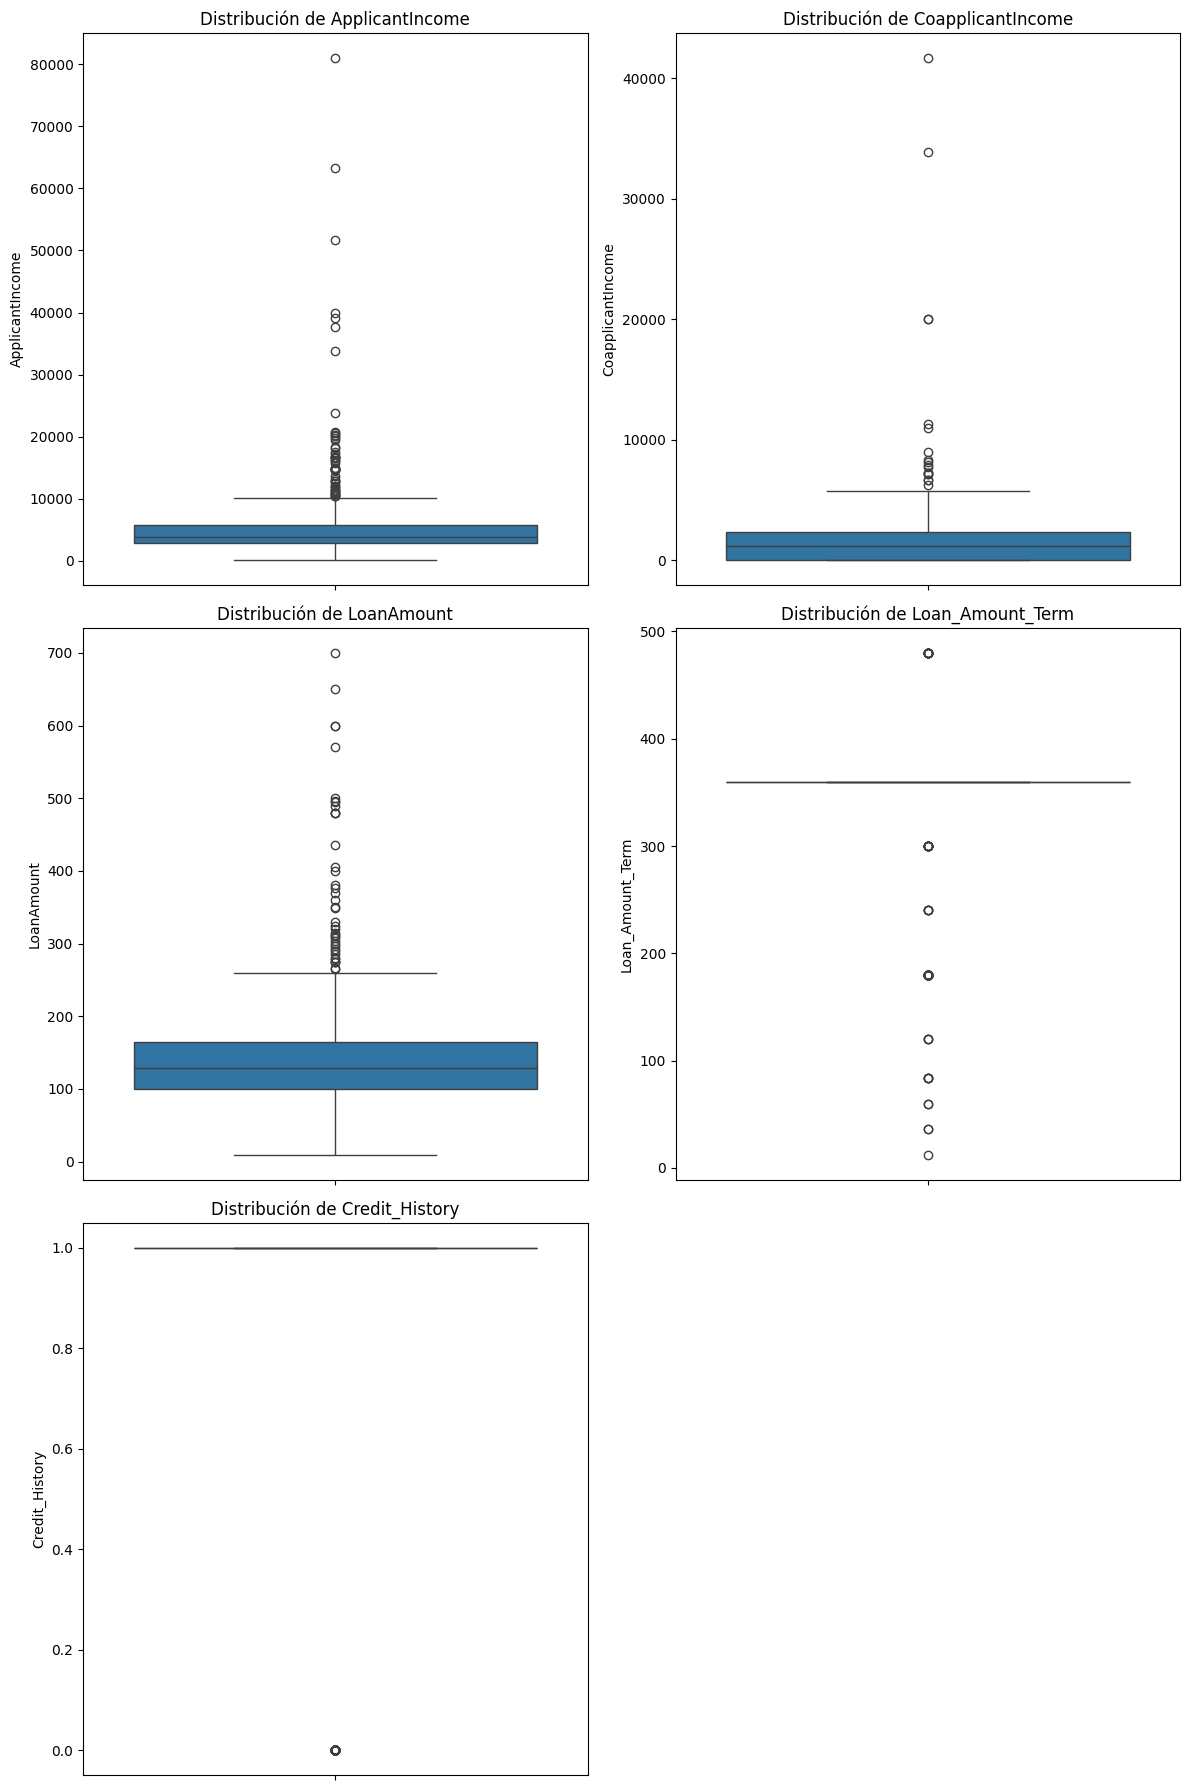

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Columnas numéricas
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns

# Calcular el número de filas y columnas necesarias para los boxplots
n_cols = 2  # Puedes ajustar el número de columnas que deseas en la visualización
n_rows = (len(numeric_columns) // n_cols) + (len(numeric_columns) % n_cols > 0)

# Generar boxplots para cada columna numérica
plt.figure(figsize=(12, 6 * n_rows))
for i, col in enumerate(numeric_columns, start=1):
    plt.subplot(n_rows, n_cols, i)  # Ajuste aquí
    sns.boxplot(df[col])
    plt.title(f'Distribución de {col}')
plt.tight_layout()
plt.show()


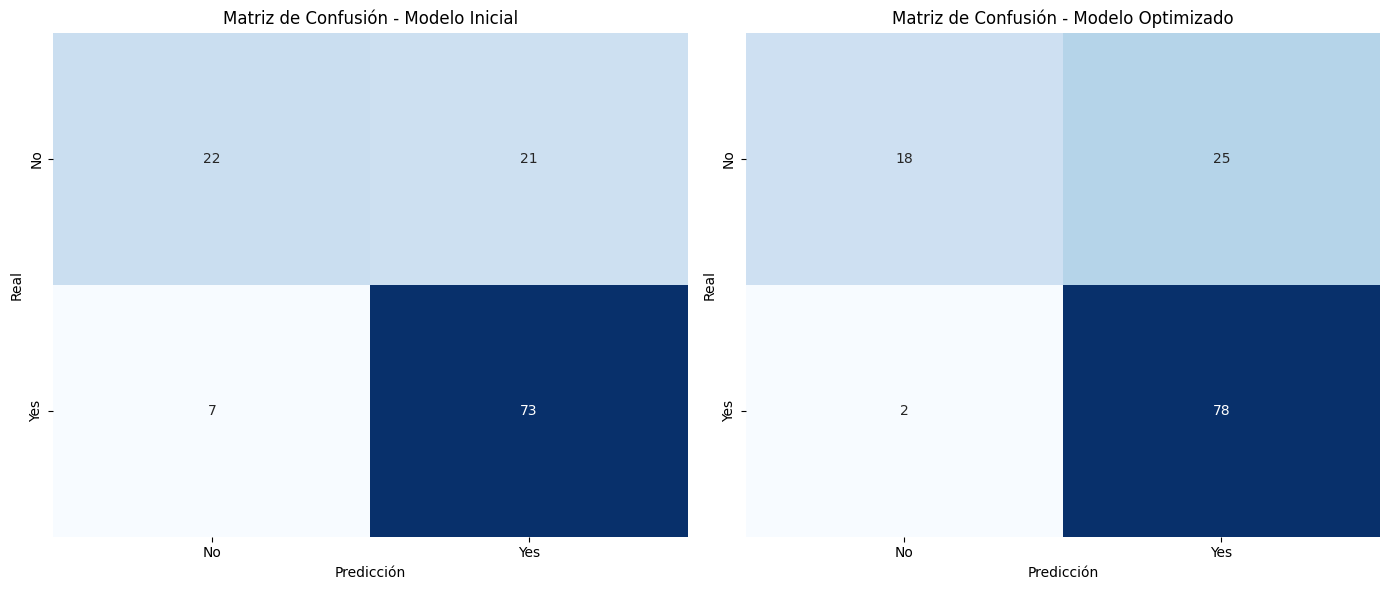

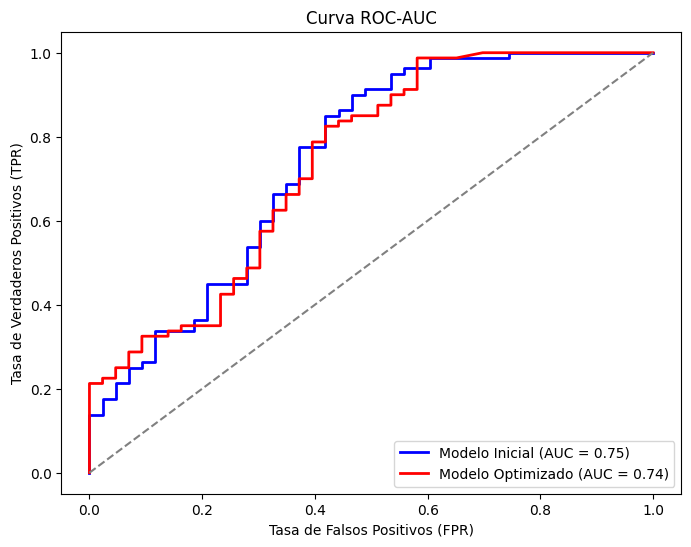


Resumen de Métricas:
     Métrica  Modelo Inicial  Modelo Optimizado
0  Exactitud        0.772358           0.780488
1  Precisión        0.776596           0.757282
2     Recall        0.912500           0.975000
3   F1-Score        0.839080           0.852459
4    ROC-AUC        0.745058           0.738081

### Conclusión:
El **Modelo Inicial** es competitivo, pero el **Modelo Optimizado** muestra un desempeño ligeramente mejor en términos de AUC-ROC.


In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
import pandas as pd

# 1. Evaluación del modelo inicial
y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1]

# Calcular las métricas del modelo inicial
accuracy_init = accuracy_score(y_test, y_pred)
precision_init = precision_score(y_test, y_pred)
recall_init = recall_score(y_test, y_pred)
f1_init = f1_score(y_test, y_pred)
roc_auc_init = roc_auc_score(y_test, y_prob)

# 2. Evaluación del modelo optimizado
y_pred_opt = best_model.predict(X_test)
y_prob_opt = best_model.predict_proba(X_test)[:, 1]

# Calcular las métricas del modelo optimizado
accuracy_opt = accuracy_score(y_test, y_pred_opt)
precision_opt = precision_score(y_test, y_pred_opt)
recall_opt = recall_score(y_test, y_pred_opt)
f1_opt = f1_score(y_test, y_pred_opt)
roc_auc_opt = roc_auc_score(y_test, y_prob_opt)

# 3. Mostrar matriz de confusión para ambos modelos
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Matriz de confusión modelo inicial
cm_init = confusion_matrix(y_test, y_pred)
sns.heatmap(cm_init, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar=False, 
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
axes[0].set_title('Matriz de Confusión - Modelo Inicial')
axes[0].set_xlabel('Predicción')
axes[0].set_ylabel('Real')

# Matriz de confusión modelo optimizado
cm_opt = confusion_matrix(y_test, y_pred_opt)
sns.heatmap(cm_opt, annot=True, fmt='d', cmap='Blues', ax=axes[1], cbar=False, 
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
axes[1].set_title('Matriz de Confusión - Modelo Optimizado')
axes[1].set_xlabel('Predicción')
axes[1].set_ylabel('Real')

plt.tight_layout()
plt.show()

# 4. Graficar la curva ROC-AUC para ambos modelos
fpr_init, tpr_init, _ = roc_curve(y_test, y_prob)
fpr_opt, tpr_opt, _ = roc_curve(y_test, y_prob_opt)

roc_auc_init = auc(fpr_init, tpr_init)
roc_auc_opt = auc(fpr_opt, tpr_opt)

plt.figure(figsize=(8, 6))
plt.plot(fpr_init, tpr_init, color='blue', lw=2, label=f'Modelo Inicial (AUC = {roc_auc_init:.2f})')
plt.plot(fpr_opt, tpr_opt, color='red', lw=2, label=f'Modelo Optimizado (AUC = {roc_auc_opt:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC-AUC')
plt.legend(loc='lower right')
plt.show()

# 5. Cuadro comparativo de las métricas
metrics_comparison = pd.DataFrame({
    'Métrica': ['Exactitud', 'Precisión', 'Recall', 'F1-Score', 'ROC-AUC'],
    'Modelo Inicial': [accuracy_init, precision_init, recall_init, f1_init, roc_auc_init],
    'Modelo Optimizado': [accuracy_opt, precision_opt, recall_opt, f1_opt, roc_auc_opt]
})

print("\nResumen de Métricas:")
print(metrics_comparison)

# 6. Señales en Markdown
if roc_auc_opt > roc_auc_init:
    print("\n### Conclusión:")
    print("El **Modelo Optimizado** es superior al **Modelo Inicial** debido a su mayor AUC-ROC, lo que indica un mejor desempeño general en la clasificación.")
else:
    print("\n### Conclusión:")
    print("El **Modelo Inicial** es competitivo, pero el **Modelo Optimizado** muestra un desempeño ligeramente mejor en términos de AUC-ROC.")

